In [13]:
import pandas as pd
import numpy as np

from pathlib import Path

from hyperpyper.utils import FolderScanner as fs
from hyperpyper.utils import DatasetRandSamplePlotter

In [26]:
DATA_PATH = Path(r"D:\data\shapetastic_60k_gs_rot")

csv_file_names = fs.get_csv_files(DATA_PATH)

csv_file_names

[WindowsPath('D:/data/shapetastic_60k_gs_rot/draw_ellipse.csv'),
 WindowsPath('D:/data/shapetastic_60k_gs_rot/draw_parallelogram.csv'),
 WindowsPath('D:/data/shapetastic_60k_gs_rot/draw_rectangle.csv')]

In [15]:
def load_data_frames(file_names):
    data_frames = []

    for file_name in file_names:
        data_frames.append(pd.read_csv(file_name))

    return pd.concat(data_frames)

In [16]:
df = load_data_frames(csv_file_names)
df

,x,y,width,height,color,rotation_angle,outline,linewidth,background_color,plot_function,file_name,skew
0,0.55,0.53,0.39,0.20,black,5.0,interpolate,3,white,draw_ellipse,0.png,NaN
1,0.48,0.55,0.90,0.19,black,145.0,interpolate,1,white,draw_ellipse,1.png,NaN
2,0.46,0.46,0.73,0.14,black,35.0,interpolate,1,white,draw_ellipse,2.png,NaN
3,0.45,0.47,0.64,0.17,black,140.0,interpolate,3,white,draw_ellipse,3.png,NaN
4,0.53,0.46,0.81,0.16,black,0.0,interpolate,2,white,draw_ellipse,4.png,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.50,0.54,0.30,0.19,black,10.0,interpolate,1,white,draw_rectangle,59995.png,NaN
59996,0.49,0.45,0.81,0.13,black,20.0,interpolate,2,white,draw_rectangle,59996.png,NaN
59997,0.48,0.49,0.47,0.17,black,145.0,interpolate,2,white,draw_rectangle,59997.png,NaN
59998,0.55,0.50,0.81,0.13,black,155.0,interpolate,1,white,draw_rectangle,59998.png,NaN


In [17]:
grouped = df.groupby('rotation_angle')

file_names = []

for group, data in grouped:
    f_names = [DATA_PATH / plot_f / f_name for (plot_f, f_name) in zip(data['plot_function'], data['file_name'])]
    file_names.append(f_names)


In [18]:
len(file_names)

36

In [19]:
from torchvision.transforms import Compose, ToTensor, Resize, CenterCrop
from hyperpyper.dataset import GenericDataset

from hyperpyper.utils import PathList

from hyperpyper.transforms import FileToPIL


class GenericTupleDataset(GenericDataset):
    """
    A generic PyTorch Dataset class for working with a list of files.

    Args:
    files (list): List of file paths or data items.
    transforms (callable, optional): A function/transform to apply to the data. Default: None.

    Returns:
    None
    """
    def __init__(self, files, transforms=None, root=None):
        self.files = PathList(files)
        self.full_files = self.files
        self.transforms = transforms

        # Add prefix to all files if necessary
        if root is not None:
            self.full_files = root / self.files


    def __len__(self):
        return len(self.files)

    
    def __getitem__(self, index):
        item = self.full_files[index]
        
        if self.transforms is not None:
            item = self.transforms(item)
        
        sample = (item, [str(self.files[index].as_posix())])

        return sample

In [20]:
from icecream import ic


transforms = Compose([FileToPIL(), Resize(32), CenterCrop(32), ToTensor()])

data_sets = []
for file_name in file_names:
    data_set = GenericTupleDataset(file_name, transforms)
    #print(len(data_set))

    data_sets.append(data_set)

#data_sets

In [21]:
data_sets[9][1]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 ['D:/data/shapetastic_60k_gs_rot_lw/draw_ellipse/57.png'])

In [22]:
len(data_sets[0])

5005

In [23]:
np.unique(df['rotation_angle'])

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175.])

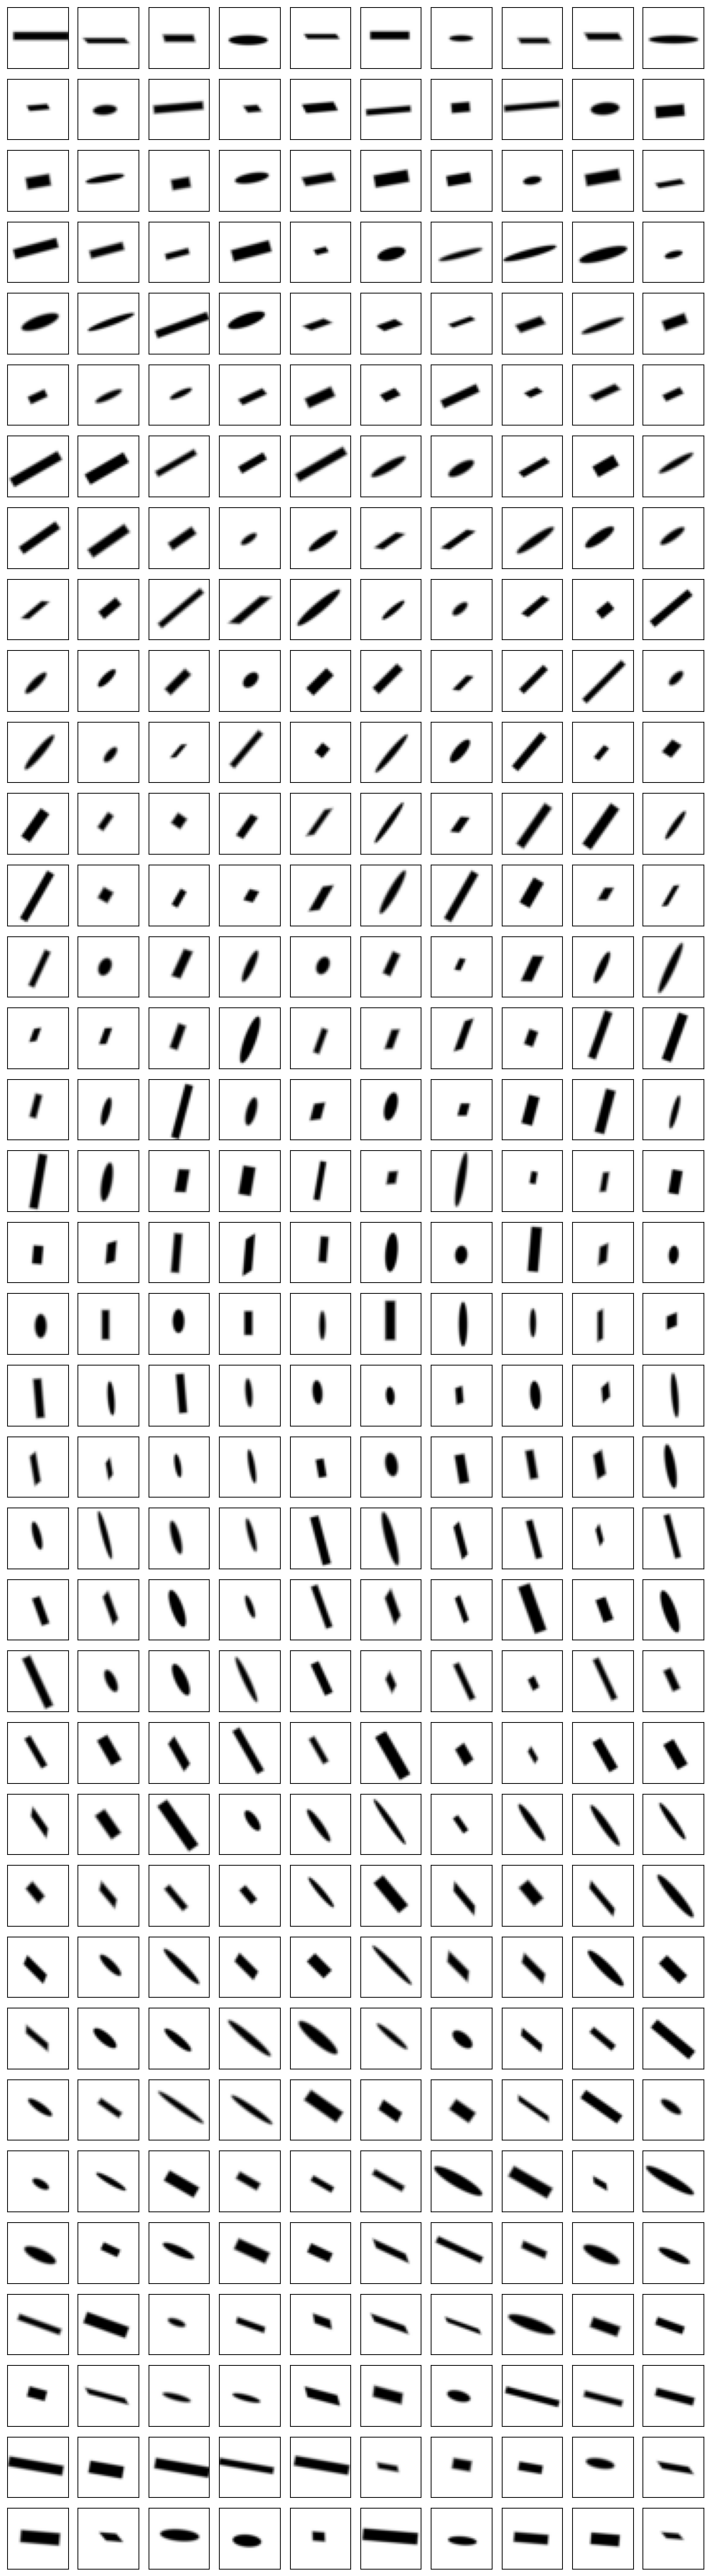

In [24]:
fig = DatasetRandSamplePlotter(dataset=data_sets,
                                n_samples=10,
                                figsize=(10,36)).plot()

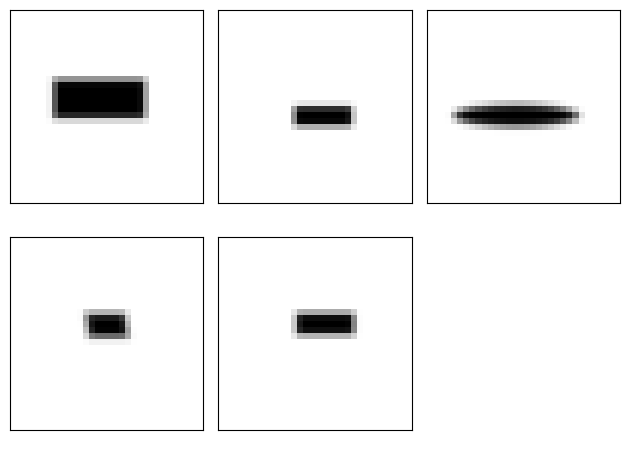

In [25]:
fig = DatasetRandSamplePlotter(data_sets[0], n_samples=5).plot()